# Example - Train a 3d U-Net for Segmentation of Pulmonary Infiltrates Associated with COVID-19
> end-to-end example on how to use `faimed3d` to train a fully 3D U-Net with a pretrained encoder 

Chest CT with present COVID-19 will be used to train a U-Net for segmentation of infiltrates. The infiltration masks,  created and published by Ma et al. (https://arxiv.org/pdf/2004.12537.pdf) will be used to train the model. T Each mask is the result of 400 minutes of manual segmentation by several domain experts. It represents one of the highest quality datasets for COVID-19 but has a relatively low sample size of 20 examinations, where 10 CT examinations are taken from the Coronacases initiative and 10 examinations form radiopaedia.
The dataset can be downloaded at https://doi.org/10.5281/zenodo.3757476.



In [2]:
from faimed3d.all import *
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

In [3]:
REPO_DIR = Path(os.getcwd()).parent
DATA_DIR = Path('/media/ScaleOut/vahldiek/CT/1_Covid-19-CT-Seg')

In [4]:
ct_images = (DATA_DIR/'coronacases').ls()
ct_images.sort()
infect_mask = (DATA_DIR/'infection_mask').ls()
infect_mask.sort()

In [5]:
d = pd.DataFrame({'images': ct_images, 
                 'masks': infect_mask})

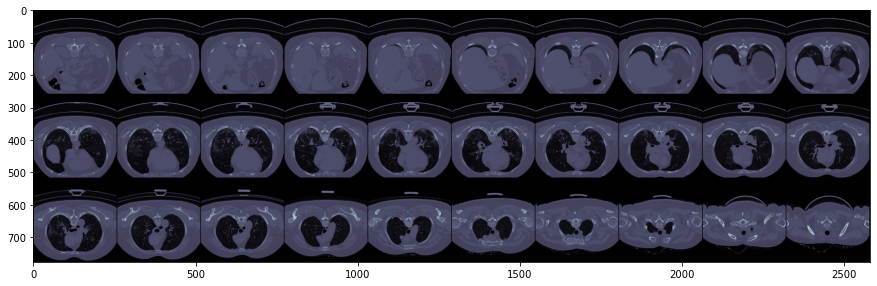

In [6]:
TensorDicom3D.create(d.images[0]).show()

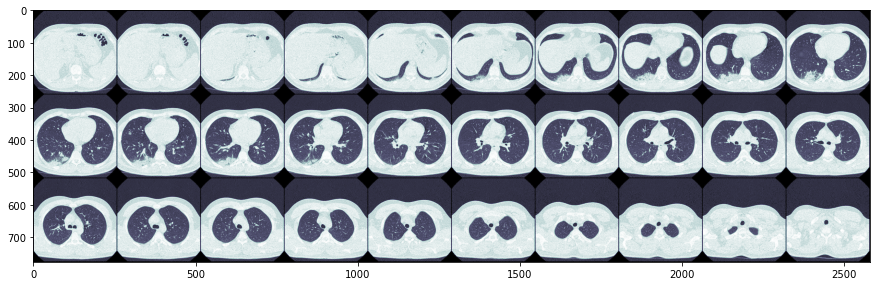

In [7]:
TensorDicom3D.create(d.images[11]).show()

The radiopeadia images have already been windowed, which will make it difficult for the model to generalize, so they are excluded.  
Training on only six images, makes the epoch very short. As at the beginning of each epoch PyTorch and fastai need some time to prepare the dataloaders and model (e.g. switch to/from evaluation mode), artificially increasing the data through oversampling can speed up the overall training process. 

In [8]:
d = d[:10] # exclude all radiopaedia cases
d['is_valid'] = [1,1,1,1,0,0,0,0,0,0]
d_oversampled = pd.concat((d, )*5) # oversample

Six images will be used for training and five for validation, so the data augmentations are increased. 

In [9]:
dls = SegmentationDataLoaders3D.from_df(d_oversampled, path = '/',
                                item_tfms = ResizeCrop3D((0, 0, 0), (20, 224, 224)), 
                                batch_tfms = [RandomPerspective3D(224, 0.5), 
                                              *aug_transforms_3d(p_all=0.15, noise=False)],
                                bs = 1, 
                                val_bs = 1,
                                splitter = ColSplitter('is_valid'))

Combining `dice_loss` and `CrossEntropyLoss` can be a helpful technique to get faster convergence.  

In [10]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

In [11]:
learn = unet_learner_3d(dls, r3d_18, n_out=2, 
                        loss_func = loss,
                        metrics = dice_score,
                        model_dir = REPO_DIR/'models',
                        cbs = [SaveModelCallback(monitor='dice_score')]
                       )
learn = learn.to_fp16()

/home/bressekk/anaconda3/envs/fastai-latest/lib/python3.8/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.43651583790779114)

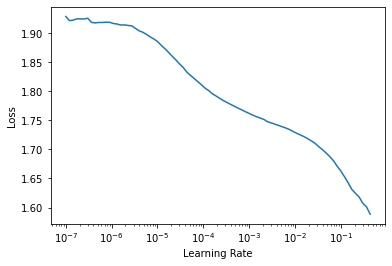

In [12]:
learn.lr_find()

The suggested learning rates by the `lr_finder` are usually to high, leading to exploding gradients. It is better to divide the suggested LR by 10 or 100. Still, training at the beginning is often unstable, but will become more stable with more epochs. `nan` for validation loss in early epochs, is not necessarily a reason to stop the training.  

In [12]:
learn.fit_one_cycle(3, 0.01, wd = 1e-4)

Better model found at epoch 0 with dice_score value: 0.022217031568288803.
Better model found at epoch 1 with dice_score value: 0.03085685335099697.
Better model found at epoch 2 with dice_score value: 0.21959252655506134.


/home/bressekk/anaconda3/envs/fastai-latest/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [13]:
learn.unfreeze()
learn.fit_one_cycle(50, 1e-3, wd = 1e-4)

Better model found at epoch 0 with dice_score value: 0.16988438367843628.
Better model found at epoch 1 with dice_score value: 0.25919052958488464.
Better model found at epoch 2 with dice_score value: 0.39445048570632935.
Better model found at epoch 4 with dice_score value: 0.49235478043556213.
Better model found at epoch 5 with dice_score value: 0.5283752679824829.
Better model found at epoch 8 with dice_score value: 0.5700957775115967.
Better model found at epoch 17 with dice_score value: 0.6103752851486206.
Better model found at epoch 18 with dice_score value: 0.6285550594329834.
Better model found at epoch 23 with dice_score value: 0.6674210429191589.
Better model found at epoch 38 with dice_score value: 0.7032817602157593.
Better model found at epoch 45 with dice_score value: 0.7204076647758484.
Better model found at epoch 49 with dice_score value: 0.736102819442749.


## Evaluation

Evalutation is done only on the original data.

In [14]:
dls = SegmentationDataLoaders3D.from_df(d, path = '/',
                                item_tfms = ResizeCrop3D((0, 0, 0), (20, 224, 224)), 
                                batch_tfms = [RandomPerspective3D(224, 0.5), 
                                              *aug_transforms_3d(p_all=0.5)],
                                bs = 1, 
                                val_bs = 1,
                                splitter = ColSplitter('is_valid'))

In [15]:
learn = learn.load('model')
inp, pred, target = learn.get_preds(with_input = True)

/home/bressekk/anaconda3/envs/fastai-latest/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


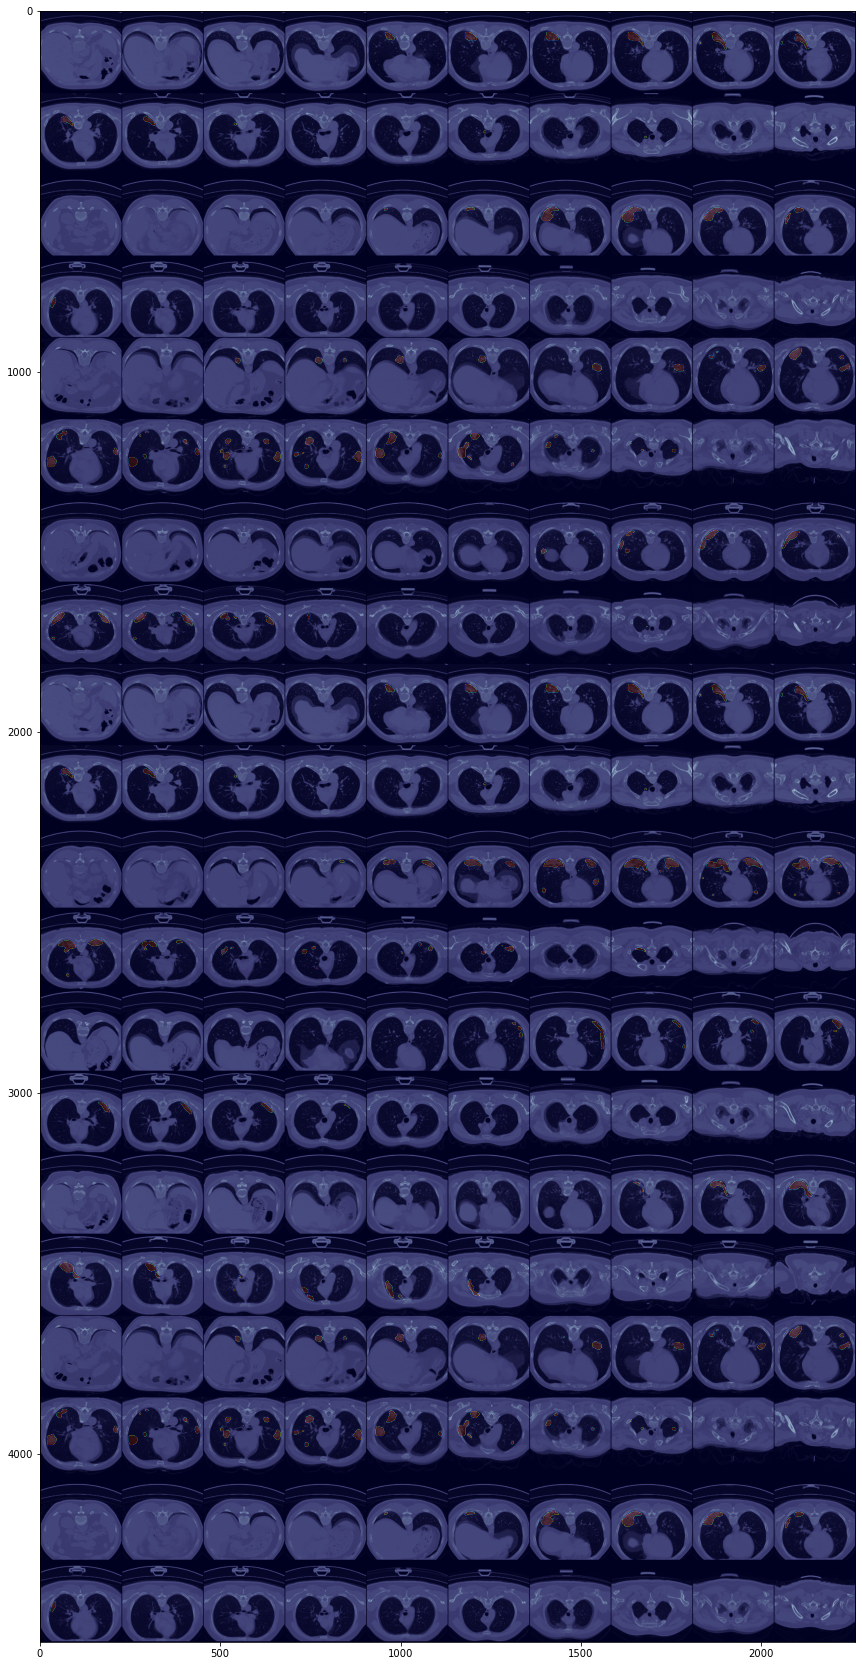

In [27]:
inp.show(nrow=10, figsize = (30, 30))
pred.argmax(1).show(nrow=10, add_to_existing = True, alpha = 0.25, cmap = 'jet')

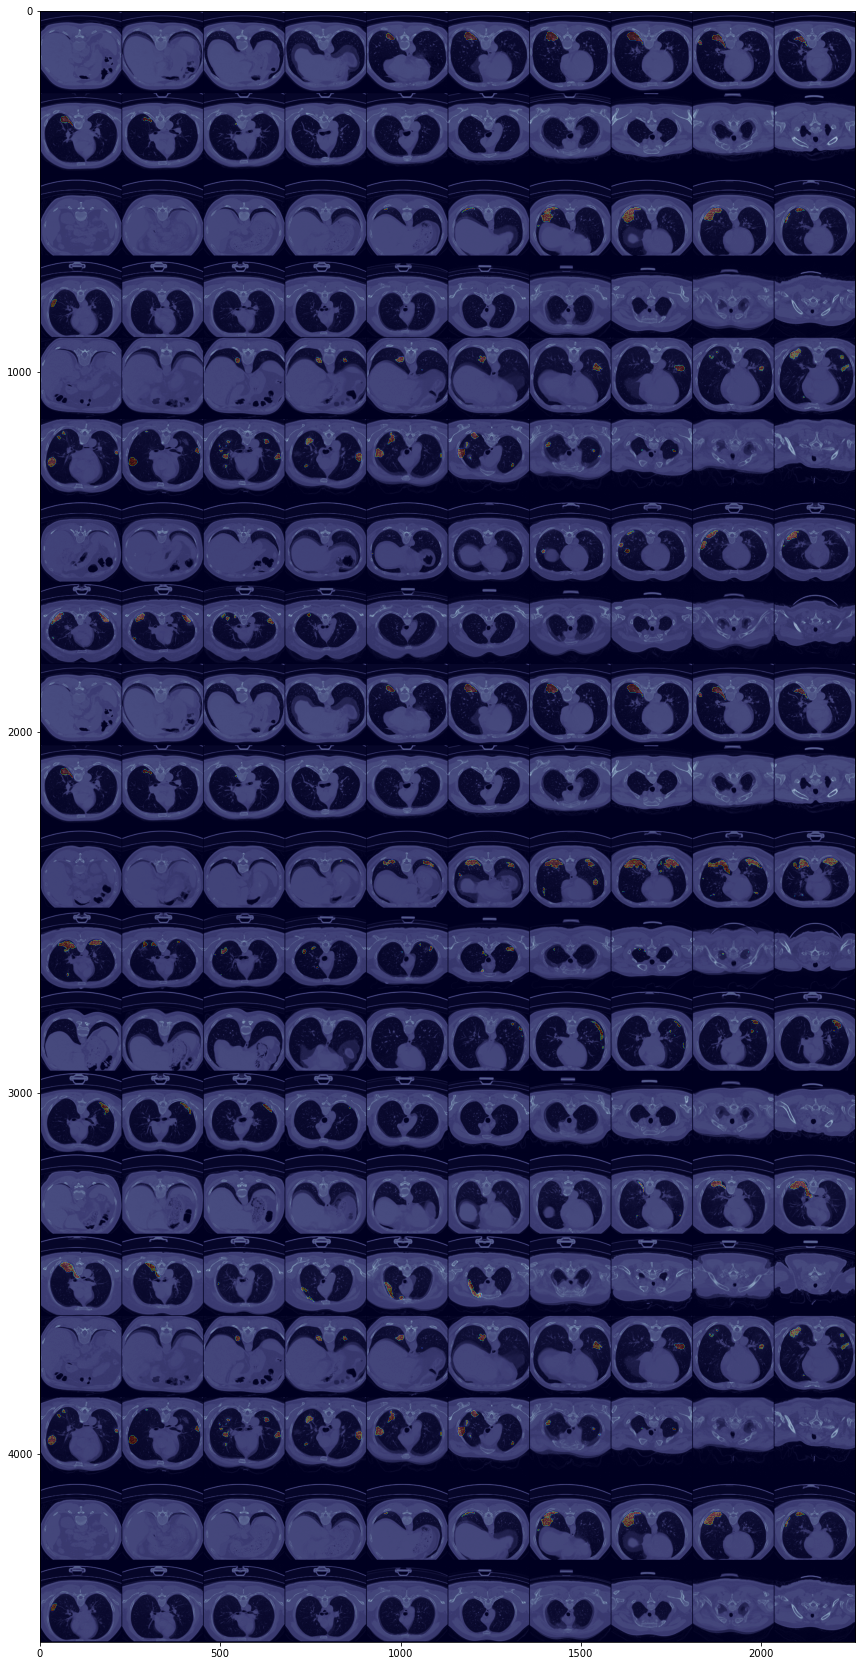

In [28]:
inp.show(nrow=10, figsize = (30, 30))
target.show(nrow=10, add_to_existing = True, alpha = 0.25, cmap = 'jet')

In [22]:
dice_score(pred, target)

TensorMask3D(0.7255)

A micro averaged dice score of 0.726 is similar to the macro averaged dice score of 0.673 as reported by Me et al. although, micro averaged scores tend to be slightly higher and Ma et al. only used four CT examinations instead of six to train the segmentation model. Still this is close to the published state of the art. 